In [1]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 14.8 MB/s 


In [2]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings; warnings.filterwarnings('ignore')
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

from pylab import rcParams
rcParams['figure.figsize'] = 20,5

In [3]:
!gdown --id 1diztKyKFfhINpY-8R_KB84kV8akW2NjD

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1diztKyKFfhINpY-8R_KB84kV8akW2NjD
To: /content/test_train_val.zip
100% 480M/480M [00:09<00:00, 50.8MB/s]


In [4]:
!unzip -qq test_train_val.zip

In [5]:
with open('test_train_val/train_meta.csv') as f:
  train_df= pd.read_csv(f)
with open('test_train_val/train_signal.csv') as f:
  train_signal = pd.read_csv(f)

with open('test_train_val/valid_meta.csv') as f:
  valid_df= pd.read_csv(f)
with open('test_train_val/valid_signal.csv') as f:
  valid_signal = pd.read_csv(f)

with open('test_train_val/test_meta.csv') as f:
  test_df= pd.read_csv(f)
with open('test_train_val/test_signal.csv') as f:
  test_signal = pd.read_csv(f)

print(train_df.shape)

train_df

(17441, 37)


ecg_id   age  sex  height  weight  nurse  site      device  NORM  MI  \
0           1  56.0    1     NaN    63.0    2.0   0.0   CS-12   E     1   0   
1           2  19.0    0     NaN    70.0    2.0   0.0   CS-12   E     1   0   
2           3  37.0    1     NaN    69.0    2.0   0.0   CS-12   E     1   0   
3           4  24.0    0     NaN    82.0    2.0   0.0   CS-12   E     1   0   
4           5  19.0    1     NaN    70.0    2.0   0.0   CS-12   E     1   0   
...       ...   ...  ...     ...     ...    ...   ...         ...   ...  ..   
17436   21832  63.0    0     NaN     NaN    1.0   2.0  AT-60    3     0   0   
17437   21833  67.0    1     NaN     NaN    1.0   2.0  AT-60    3     0   0   
17438   21834  93.0    0     NaN     NaN    1.0   2.0  AT-60    3     1   0   
17439   21835  59.0    1     NaN     NaN    1.0   2.0  AT-60    3     0   0   
17440   21836  64.0    1     NaN     NaN    1.0   2.0  AT-60    3     1   0   

       ...  sub_ISC_  sub_SEHYP  sub_ISCI  sub_CRBBB  sub_CLBBB  sub_LAO/LAE  \
0      ...         0          0         0          0          0            0   
1      ...         0          0         0          0          0            0   
2      ...         0          0         0          0          0            0   
3      ...         0          0         0          0          0            0   
4      ...         0          0         0          0          0            0   
...    ...       ...        ...       ...        ...        ...          ...   
17436  ...         0          0         0          0          0            0   
17437  ...         0          0         0          0          0            0   
17438  ...         0          0         0          0          0            0   
17439  ...         0          0         0          0          0            0   
17440  ...         0          0         0          0          0            0   

       sub_ILBBB  sub_WPW  sub_PMI  strat_fold  
0              0        0        0           3  
1              0        0        0           2  
2              0        0        0           5  
3              0        0        0           3  
4              0        0        0           4  
...          ...      ...      ...         ...  
17436          0        0        0           7  
17437          0        0        0           7  
17438          0        0        0           4  
17439          0        0        0           2  
17440          0        0        0           8  

[17441 rows x 37 columns]

In [ ]:
# train_df=pd.read_csv("C:/Users/Abdulhaq/Documents/test_train_val/test_train_val/train_meta.csv")
# train_signal=pd.read_csv("C:/Users/Abdulhaq/Documents/test_train_val/test_train_val/train_signal.csv")


# valid_df=pd.read_csv("C:/Users/Abdulhaq/Documents/test_train_val/test_train_val/valid_meta.csv")
# valid_signal=pd.read_csv("C:/Users/Abdulhaq/Documents/test_train_val/test_train_val/valid_signal.csv")


# test_df=pd.read_csv("C:/Users/Abdulhaq/Documents/test_train_val/test_train_val/test_meta.csv")
# test_signal=pd.read_csv("C:/Users/Abdulhaq/Documents/test_train_val/test_train_val/test_signal.csv")


# print(train_df.shape)

# train_df

In [6]:
class PTBXLDatasetPreprocesser():
    def __init__(self):
        pass
    
    def save(self, filename):
        data = {
            'superclass_cols': self.superclass_cols,
            'subclass_cols': self.subclass_cols,
            'meta_num_cols': self.meta_num_cols,
            'meta_num_means': self.meta_num_means,
            'min_max_scaler': self.min_max_scaler,
            'meta_cat_cols': self.meta_cat_cols,
            'cat_lablers': self.cat_lablers,
            'bclass_cols': self.bclass_cols,
            
        }
        pd.to_pickle(data, filename)
        
    def load(self, filename):
        data = pd.read_pickle(filename)
        self.min_max_scaler = data['min_max_scaler']
        self.cat_lablers = data['cat_lablers']
        #self.binary_lablers = data['binary_lablers']
        
    def fit(self, x, y):
        x = x.copy()
        y = y.copy()
        
        self.superclass_cols = [ 'MI', 'STTC', 'CD', 'HYP']
        
        self.subclass_cols = [col for col in y.columns if 'sub_' in col]

        self.bclass_cols = ['NORM']
        
        self.meta_num_cols = ['age', 'height', 'weight']
        self.meta_num_means = []
        for col in self.meta_num_cols:
            print(col, y[col].mean())
            y[col] = y[col].fillna(y[col].mean())
            self.meta_num_means += [y[col].mean()]
            
        self.min_max_scaler = MinMaxScaler().fit(y[self.meta_num_cols])
        
        self.meta_cat_cols = ['sex'] #, 'nurse', 'device']
        self.cat_lablers = [LabelEncoder().fit(y[col].fillna('none').astype(str)) for col in self.meta_cat_cols]
        return self

        #self.min_max_scaler = MinMaxScaler().fit(y[self.meta_num_cols])
        
        #self.meta_binary_cols = ['NORM'] 
        #self.binary_lablers = [LabelEncoder().fit(y[col].fillna('none').astype(str)) for col in self.meta_binary_cols]
        #return self
    
    def transform(self, x, y):
        
        channel_cols = x.columns.tolist()[1:]
        
        ret = []
        x = x[channel_cols].values.reshape(-1, 1000, 12)
        print(x.shape)
        ret += [x] # signal
        
        y_ = y.copy()
        
        for i, col in enumerate(self.meta_num_cols):
            y_[col] = y_[col].fillna(self.meta_num_means[i])
        y_[self.meta_num_cols] = self.min_max_scaler.transform(y_[self.meta_num_cols])
        y_[self.meta_num_cols] = np.clip(y_[self.meta_num_cols], 0., 1.) # prevent extreme value far from train set
        
        ret += [y_[self.meta_num_cols]] # meta num features
        
        for i, col in enumerate(self.meta_cat_cols):
            y_[col] = y_[col].fillna('none').astype(str)
            y_[col] = self.cat_lablers[i].transform(y_[col]) 
        
        ret += [y_[self.meta_cat_cols]] # meta cat features

        #for i, col in enumerate(self.meta_binary_cols):
           # y_[col] = y_[col].fillna('none').astype(str)
           # y_[col] = self.binary_lablers[i].transform(y_[col]) 
        
        #ret += [y_[self.meta_binary_cols]] # binary class target
        
        if np.isin(self.superclass_cols, y.columns).sum() == len(self.superclass_cols):
            ret += [y[self.superclass_cols].fillna(0).astype(int)] # superclass targets
        
        if np.isin(self.subclass_cols, y.columns).sum() == len(self.subclass_cols):
            ret += [y[self.subclass_cols].fillna(0).astype(int)] # subclass targets

        if np.isin(self.bclass_cols, y.columns).sum() == len(self.bclass_cols):
            ret += [y[self.bclass_cols].fillna(0).astype(int)]
        
        return ret

In [7]:
data_preprocessor = PTBXLDatasetPreprocesser()
data_preprocessor.fit(train_signal, train_df)
train_signal, train_meta_num_feats, train_meta_cat_feats, train_superclass, train_subclass, train_bclass = data_preprocessor.transform(train_signal, train_df)
valid_signal, valid_meta_num_feats, valid_meta_cat_feats, valid_superclass, valid_subclass, valid_bclass = data_preprocessor.transform(valid_signal, valid_df)
test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass, test_bclass = data_preprocessor.transform(test_signal, test_df)

print(train_signal.shape)
print(valid_meta_num_feats.isna().sum(), valid_meta_cat_feats.isna().sum(), valid_superclass.isna().sum(), valid_subclass.isna().sum(), valid_bclass.isna().sum())

display(train_meta_num_feats)
display(train_meta_cat_feats)
display(train_superclass)
display(train_subclass)
display(train_bclass)

age 59.63709074169975
height 166.68908469699693
weight 70.69599447513812
(17441, 1000, 12)
(2193, 1000, 12)
(2203, 1000, 12)
(17441, 1000, 12)
age       0
height    0
weight    0
dtype: int64 sex    0
dtype: int64 MI      0
STTC    0
CD      0
HYP     0
dtype: int64 sub_NORM         0
sub_IMI          0
sub_STTC         0
sub_NST_         0
sub_LVH          0
sub_LAFB/LPFB    0
sub_RVH          0
sub_RAO/RAE      0
sub_IRBBB        0
sub_IVCD         0
sub_LMI          0
sub_AMI          0
sub__AVB         0
sub_ISCA         0
sub_ISC_         0
sub_SEHYP        0
sub_ISCI         0
sub_CRBBB        0
sub_CLBBB        0
sub_LAO/LAE      0
sub_ILBBB        0
sub_WPW          0
sub_PMI          0
dtype: int64 NORM    0
dtype: int64


age    height    weight
0      0.580645  0.791572  0.282927
1      0.182796  0.791572  0.317073
2      0.376344  0.791572  0.312195
3      0.236559  0.791572  0.375610
4      0.182796  0.791572  0.317073
...         ...       ...       ...
17436  0.655914  0.791572  0.320468
17437  0.698925  0.791572  0.320468
17438  0.978495  0.791572  0.320468
17439  0.612903  0.791572  0.320468
17440  0.666667  0.791572  0.320468

[17441 rows x 3 columns]

sex
0        1
1        0
2        1
3        0
4        1
...    ...
17436    0
17437    1
17438    0
17439    1
17440    1

[17441 rows x 1 columns]

MI  STTC  CD  HYP
0       0     0   0    0
1       0     0   0    0
2       0     0   0    0
3       0     0   0    0
4       0     0   0    0
...    ..   ...  ..  ...
17436   0     0   1    0
17437   0     1   0    0
17438   0     0   0    0
17439   0     1   0    0
17440   0     0   0    0

[17441 rows x 4 columns]

sub_NORM  sub_IMI  sub_STTC  sub_NST_  sub_LVH  sub_LAFB/LPFB  sub_RVH  \
0             1        0         0         0        0              0        0   
1             1        0         0         0        0              0        0   
2             1        0         0         0        0              0        0   
3             1        0         0         0        0              0        0   
4             1        0         0         0        0              0        0   
...         ...      ...       ...       ...      ...            ...      ...   
17436         0        0         0         0        0              1        0   
17437         0        0         1         0        0              0        0   
17438         1        0         0         0        0              0        0   
17439         0        0         0         0        0              0        0   
17440         1        0         0         0        0              0        0   

       sub_RAO/RAE  sub_IRBBB  sub_IVCD  ...  sub_ISCA  sub_ISC_  sub_SEHYP  \
0                0          0         0  ...         0         0          0   
1                0          0         0  ...         0         0          0   
2                0          0         0  ...         0         0          0   
3                0          0         0  ...         0         0          0   
4                0          0         0  ...         0         0          0   
...            ...        ...       ...  ...       ...       ...        ...   
17436            0          0         1  ...         0         0          0   
17437            0          0         0  ...         0         0          0   
17438            0          0         0  ...         0         0          0   
17439            0          0         0  ...         1         0          0   
17440            0          0         0  ...         0         0          0   

       sub_ISCI  sub_CRBBB  sub_CLBBB  sub_LAO/LAE  sub_ILBBB  sub_WPW  \
0             0          0          0            0          0        0   
1             0          0          0            0          0        0   
2             0          0          0            0          0        0   
3             0          0          0            0          0        0   
4             0          0          0            0          0        0   
...         ...        ...        ...          ...        ...      ...   
17436         0          0          0            0          0        0   
17437         0          0          0            0          0        0   
17438         0          0          0            0          0        0   
17439         0          0          0            0          0        0   
17440         0          0          0            0          0        0   

       sub_PMI  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
17436        0  
17437        0  
17438        0  
17439        0  
17440        0  

[17441 rows x 23 columns]

NORM
0         1
1         1
2         1
3         1
4         1
...     ...
17436     0
17437     0
17438     1
17439     0
17440     1

[17441 rows x 1 columns]

In [ ]:
#new_df= np.hstack((train_meta_num_feats, train_meta_cat_feats))
#new_df.shape
#new_df

In [8]:
train_bclass.value_counts()

NORM
0       9834
1       7607
dtype: int64

In [9]:
valid_bclass.value_counts()

NORM
0       1236
1        957
dtype: int64

In [10]:
test_bclass.value_counts()

NORM
0       1239
1        964
dtype: int64

In [ ]:
signal=np.array(train_signal)
signal.shape
#print(signal)

(17441, 1000, 12)

In [ ]:
# newsignal= signal.reshape(17441,10,100,12)


In [ ]:
target=np.array(train_bclass)
target.shape

(17441, 1)

In [ ]:
v_signal=np.array(valid_signal)

In [ ]:
v_signal.shape

(2193, 1000, 12)

In [ ]:
#newv_signal=v_signal.reshape(2193,10,100,12)

In [ ]:
v_target=np.array(valid_bclass)
v_target.shape

(2193, 1)

In [ ]:
!pip install ecg-plot
#import physionet_challenge_utility_script as pc
import ecg_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
#from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional, ConvLSTM1D
from keras.models import Sequential, Model
#from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, auc
from keras.layers import concatenate
from scipy import optimize
from scipy.io import loadmat
import os
%load_ext autoreload
%autoreload
%reload_ext autoreload

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=3
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

In [ ]:
vot = []

**Binary Classification on ECG ataset**

**ANN MODEL**

In [ ]:
ann_model = Sequential()
ann_model.add(Dense(50, activation='relu', input_shape=(1000,12)))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(GlobalAveragePooling1D())
ann_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# ann_model.summary()

In [ ]:
# plot_model(ann_model)

In [ ]:
batchsize = 32
ann_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=[reduce_lr,early_stop], validation_data=(v_signal,v_target))

Epoch 1/30
546/546 [==============================] - 14s 18ms/step - loss: 0.5338 - accuracy: 0.7241 - auc: 0.8134 - val_loss: 0.4448 - val_accuracy: 0.7957 - val_auc: 0.8741 - lr: 0.0010
Epoch 2/30
546/546 [==============================] - 8s 15ms/step - loss: 0.4266 - accuracy: 0.8057 - auc: 0.8841 - val_loss: 0.4168 - val_accuracy: 0.8053 - val_auc: 0.8877 - lr: 0.0010
Epoch 3/30
546/546 [==============================] - 8s 15ms/step - loss: 0.4095 - accuracy: 0.8158 - auc: 0.8928 - val_loss: 0.4331 - val_accuracy: 0.8053 - val_auc: 0.8863 - lr: 0.0010
Epoch 4/30
546/546 [==============================] - 7s 13ms/step - loss: 0.4013 - accuracy: 0.8177 - auc: 0.8962 - val_loss: 0.4167 - val_accuracy: 0.7957 - val_auc: 0.8939 - lr: 0.0010
Epoch 5/30
546/546 [==============================] - 8s 16ms/step - loss: 0.3951 - accuracy: 0.8219 - auc: 0.8996 - val_loss: 0.4056 - val_accuracy: 0.8153 - val_auc: 0.8944 - lr: 0.0010
Epoch 6/30
546/546 [==============================] - 8s 15

Text(0, 0.5, 'Accuracy')

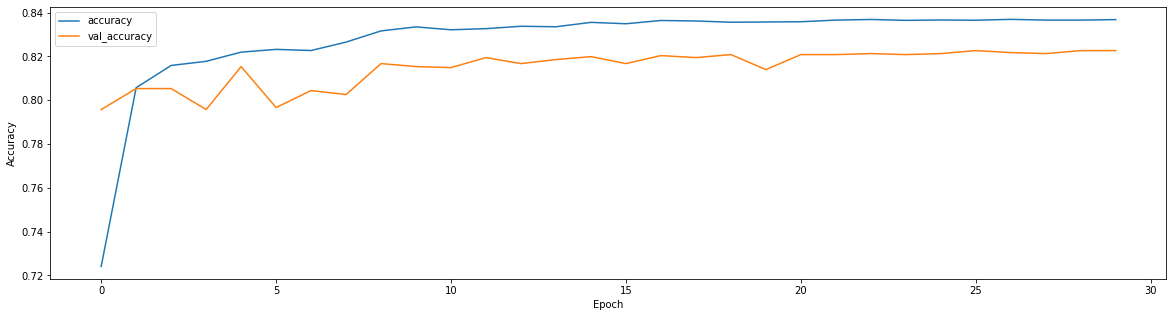

In [ ]:
plt.plot(ann_model.history.history['accuracy'])
# plt.plot(ann_model.history.history['Precision'])
plt.plot(ann_model.history.history['val_accuracy'])
# plt.plot(ann_model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

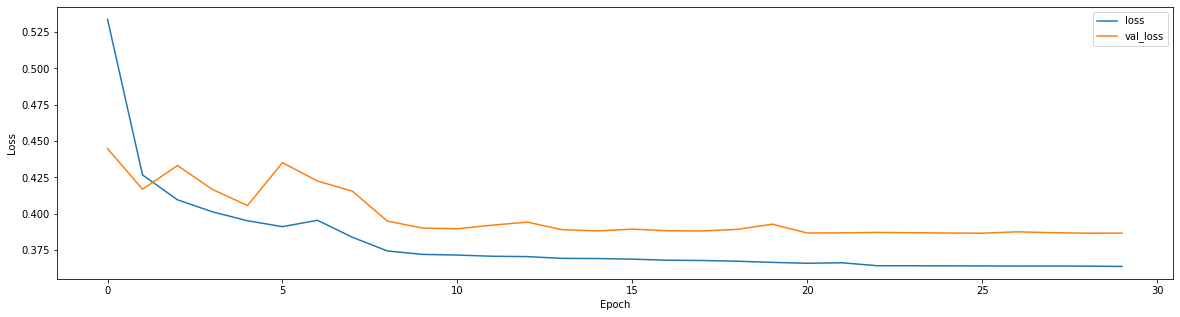

In [ ]:
plt.plot(ann_model.history.history['loss'])
plt.plot(ann_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# plt.plot(ann_model.history.history['Recall'])
# plt.plot(ann_model.history.history['Precision'])
# plt.plot(ann_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
y1_pred=ann_model.predict(test_signal)
predict_1=[int(x+0.5) for x in y1_pred]
vot.append(np.array(predict_1))
conf_mat=confusion_matrix(test_bclass,predict_1)
print(conf_mat)

[[975 264]
 [162 802]]


In [ ]:
accuracy_score(test_bclass,predict_1)

0.8066273263731275

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_bclass, y1_pred)
metrics.auc(fpr, tpr)

0.8913383835846738

**CNN MODEL**

**Lenet-5 model**

In [ ]:
lenet_5_model=Sequential()

lenet_5_model.add(Conv1D(filters=6, kernel_size=3, padding='same', input_shape=(1000,12)))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(Conv1D(filters=16, strides=1, kernel_size=5))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(GlobalAveragePooling1D())

lenet_5_model.add(Dense(64, activation='relu'))

lenet_5_model.add(Dense(32, activation='relu'))

lenet_5_model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
# lenet_5_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
lenet_5_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# lenet_5_model.summary()

In [ ]:
# plot_model(lenet_5_model)

In [ ]:
batchsize = 32
lenet_5_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=[reduce_lr,early_stop], validation_data=(v_signal,v_target))

Epoch 1/30
546/546 [==============================] - 15s 9ms/step - loss: 0.5122 - accuracy: 0.7333 - auc: 0.8205 - val_loss: 0.4348 - val_accuracy: 0.7939 - val_auc: 0.8777 - lr: 0.0010
Epoch 2/30
546/546 [==============================] - 4s 7ms/step - loss: 0.4284 - accuracy: 0.7987 - auc: 0.8794 - val_loss: 0.4372 - val_accuracy: 0.7880 - val_auc: 0.8923 - lr: 0.0010
Epoch 3/30
546/546 [==============================] - 4s 7ms/step - loss: 0.4116 - accuracy: 0.8057 - auc: 0.8894 - val_loss: 0.4798 - val_accuracy: 0.7597 - val_auc: 0.8988 - lr: 0.0010
Epoch 4/30
546/546 [==============================] - 4s 7ms/step - loss: 0.3968 - accuracy: 0.8147 - auc: 0.8978 - val_loss: 0.3976 - val_accuracy: 0.8085 - val_auc: 0.9008 - lr: 0.0010
Epoch 5/30
546/546 [==============================] - 4s 7ms/step - loss: 0.3944 - accuracy: 0.8170 - auc: 0.8989 - val_loss: 0.3937 - val_accuracy: 0.8057 - val_auc: 0.9005 - lr: 0.0010
Epoch 6/30
546/546 [==============================] - 4s 7ms/ste

Text(0, 0.5, 'Accuracy')

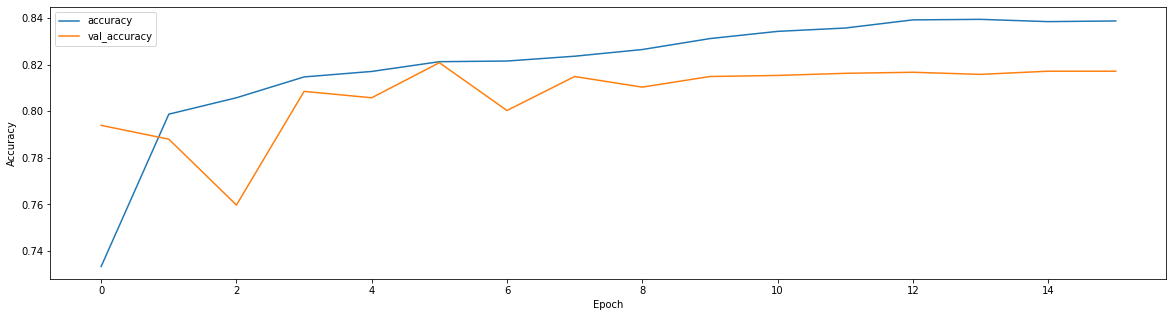

In [ ]:
plt.plot(lenet_5_model.history.history['accuracy'])
# plt.plot(lenet_5_model.history.history['Precision'])
plt.plot(lenet_5_model.history.history['val_accuracy'])
# plt.plot(lenet_5_model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

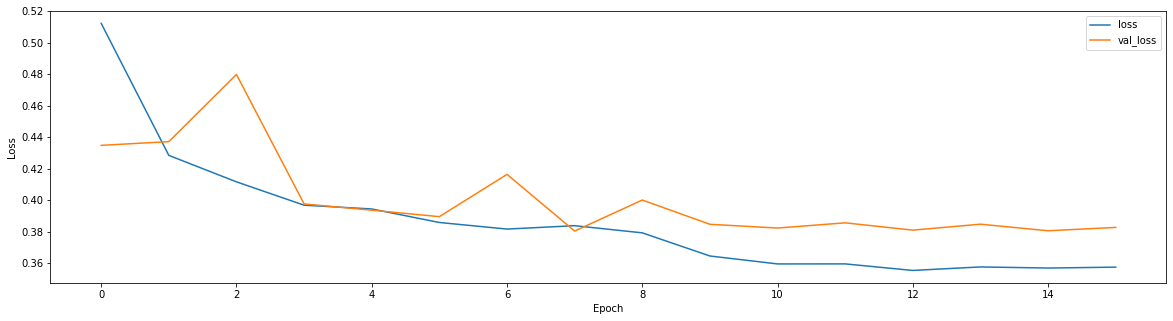

In [ ]:
plt.plot(lenet_5_model.history.history['loss'])
plt.plot(lenet_5_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# plt.plot(lenet_5_model.history.history['Recall'])
# plt.plot(lenet_5_model.history.history['Precision'])
# plt.plot(lenet_5_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
y2_pred=lenet_5_model.predict(test_signal)
predict_2=[int (x+0.5) for x in y2_pred]
vot.append(np.array(predict_2))
conf_mat=confusion_matrix(test_bclass,predict_2)
print(conf_mat)

[[948 291]
 [120 844]]


In [ ]:
accuracy_score(test_bclass,predict_2)

0.8134362233318202

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_bclass, y2_pred)
metrics.auc(fpr, tpr)

0.9065410466880333

**AlexNet model**

In [ ]:
alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, kernel_size=11, strides=4, input_shape=(1000,12)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(GlobalAveragePooling1D())
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# alexNet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
alexNet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
alexNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 248, 96)           12768     
                                                                 
 batch_normalization_2 (Batc  (None, 248, 96)          384       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 248, 96)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 124, 96)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 124, 256)          123136    
                                                                 
 batch_normalization_3 (Batc  (None, 124, 256)        

In [ ]:
# plot_model(alexNet_model)

In [ ]:
batchsize = 32
alexNet_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=[reduce_lr,early_stop],  validation_data=(v_signal,v_target))

Epoch 1/30
546/546 [==============================] - 13s 18ms/step - loss: 0.3864 - accuracy: 0.8289 - auc: 0.9052 - val_loss: 0.3557 - val_accuracy: 0.8495 - val_auc: 0.9295 - lr: 0.0010
Epoch 2/30
546/546 [==============================] - 8s 15ms/step - loss: 0.3287 - accuracy: 0.8556 - auc: 0.9320 - val_loss: 0.3638 - val_accuracy: 0.8363 - val_auc: 0.9346 - lr: 0.0010
Epoch 3/30
546/546 [==============================] - 8s 16ms/step - loss: 0.3144 - accuracy: 0.8669 - auc: 0.9378 - val_loss: 0.3114 - val_accuracy: 0.8614 - val_auc: 0.9394 - lr: 0.0010
Epoch 4/30
546/546 [==============================] - 9s 16ms/step - loss: 0.3020 - accuracy: 0.8739 - auc: 0.9426 - val_loss: 0.3308 - val_accuracy: 0.8518 - val_auc: 0.9347 - lr: 0.0010
Epoch 5/30
546/546 [==============================] - 8s 15ms/step - loss: 0.2957 - accuracy: 0.8748 - auc: 0.9449 - val_loss: 0.3299 - val_accuracy: 0.8573 - val_auc: 0.9392 - lr: 0.0010
Epoch 6/30
546/546 [==============================] - 8s 15

Text(0, 0.5, 'Accuracy')

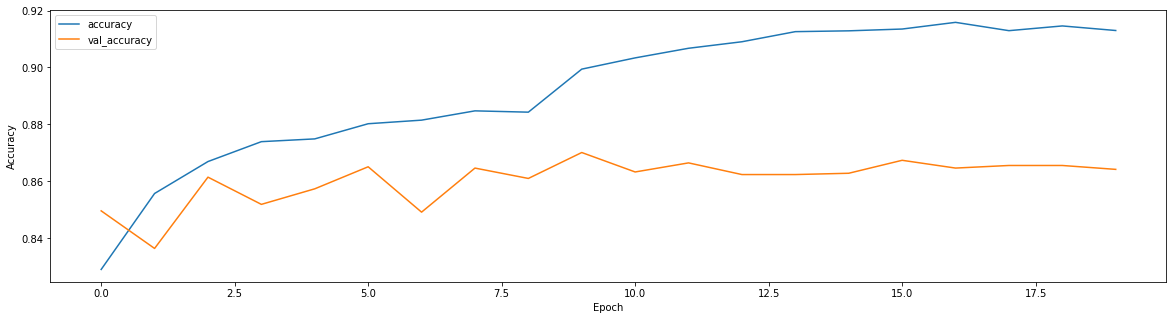

In [ ]:
plt.plot(alexNet_model.history.history['accuracy'])
# plt.plot(alexNet_model.history.history['Precision'])
plt.plot(alexNet_model.history.history['val_accuracy'])
# plt.plot(alexNet_model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

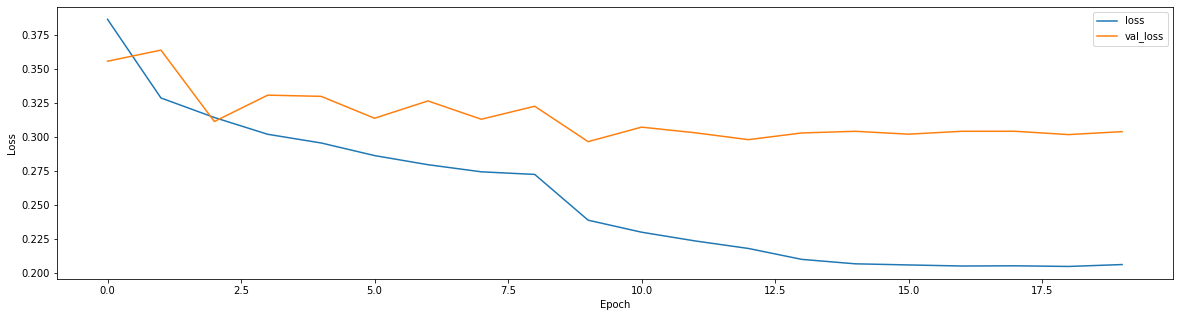

In [ ]:
plt.plot(alexNet_model.history.history['loss'])
plt.plot(alexNet_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# plt.plot(alexNet_model.history.history['Recall'])
# plt.plot(alexNet_model.history.history['Precision'])
# plt.plot(alexNet_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
y3_pred=alexNet_model.predict(test_signal)
predict_3=[int(x+0.5) for x in y3_pred]
vot.append(np.array(predict_3))
conf_mat=confusion_matrix(test_bclass,predict_3)
print(conf_mat)

[[1035  204]
 [  97  867]]


In [ ]:
accuracy_score(test_bclass,predict_3)

0.8633681343622334

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_bclass, y3_pred)
metrics.auc(fpr, tpr)

0.9419673207211009

**VGG 16**

In [ ]:
vgg_16_model=Sequential()

vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same',  input_shape=(1000,12)))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(GlobalAveragePooling1D())
vgg_16_model.add(Dense(256, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(128, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(1, activation='sigmoid'))

In [ ]:
#  vgg_16_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
vgg_16_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# vgg_16_model.summary()

In [ ]:
# plot_model(vgg_16_model)

In [ ]:
batchsize = 32
vgg_16_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=[reduce_lr,early_stop],  validation_data=(v_signal,v_target))

Epoch 1/30
546/546 [==============================] - 41s 67ms/step - loss: 0.3939 - accuracy: 0.8288 - auc: 0.9026 - val_loss: 0.8846 - val_accuracy: 0.7629 - val_auc: 0.9098 - lr: 0.0010
Epoch 2/30
546/546 [==============================] - 35s 65ms/step - loss: 0.3387 - accuracy: 0.8562 - auc: 0.9283 - val_loss: 0.3370 - val_accuracy: 0.8623 - val_auc: 0.9319 - lr: 0.0010
Epoch 3/30
546/546 [==============================] - 35s 64ms/step - loss: 0.3198 - accuracy: 0.8679 - auc: 0.9368 - val_loss: 0.4190 - val_accuracy: 0.8235 - val_auc: 0.9197 - lr: 0.0010
Epoch 4/30
546/546 [==============================] - 35s 64ms/step - loss: 0.3088 - accuracy: 0.8696 - auc: 0.9404 - val_loss: 0.3895 - val_accuracy: 0.8395 - val_auc: 0.9181 - lr: 0.0010
Epoch 5/30
546/546 [==============================] - 35s 64ms/step - loss: 0.2970 - accuracy: 0.8742 - auc: 0.9447 - val_loss: 0.3603 - val_accuracy: 0.8336 - val_auc: 0.9254 - lr: 0.0010
Epoch 6/30
546/546 [==============================] - 3

Text(0, 0.5, 'Accuracy')

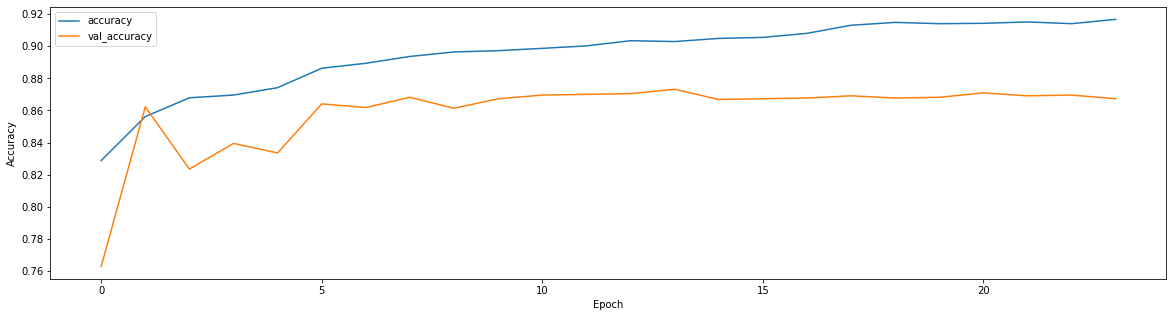

In [ ]:
plt.plot(vgg_16_model.history.history['accuracy'])
# plt.plot(vgg_16_model.history.history['Precision'])
plt.plot(vgg_16_model.history.history['val_accuracy'])
# plt.plot(vgg_16_model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

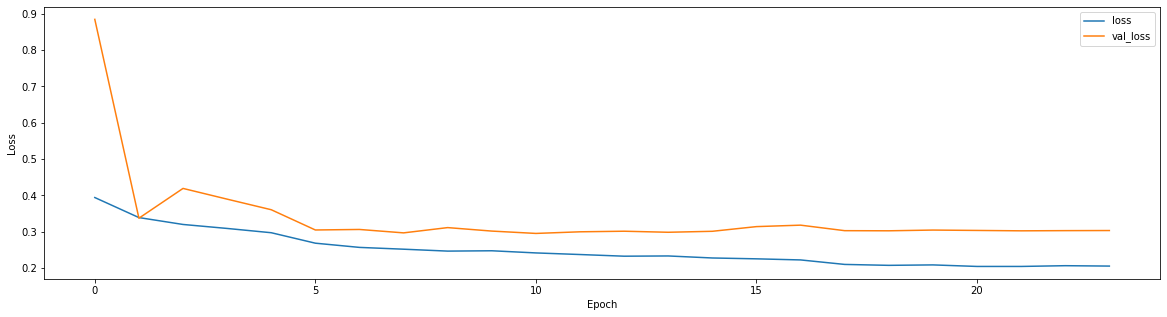

In [ ]:
plt.plot(vgg_16_model.history.history['loss'])
plt.plot(vgg_16_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# plt.plot(vgg_16_model.history.history['Recall'])
# plt.plot(vgg_16_model.history.history['Precision'])
# plt.plot(vgg_16_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
y4_pred=vgg_16_model.predict(test_signal)
predict_4=[int(x+0.5) for x in y4_pred]
vot.append(np.array(predict_4))
conf_mat=confusion_matrix(test_bclass,predict_4)
print(conf_mat)

[[1039  200]
 [  91  873]]


In [ ]:
accuracy_score(test_bclass,predict_4)

0.8679073990013618

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_bclass, y4_pred)
metrics.auc(fpr, tpr)

0.9426747912752554

**Resnet 50 Model**

In [ ]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv1D(filters = F1, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv1D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv1D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape):
    
    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(64, 7, strides = 2)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(1,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
resNet50_model = ResNet50(input_shape = (1000,12))

In [ ]:
# resNet50_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
resNet50_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# resNet50_model.summary()

In [ ]:
# plot_model(resNet50_model)

In [ ]:
batchsize = 32
resNet50_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=[reduce_lr,early_stop],  validation_data=(v_signal,v_target))

Epoch 1/30
546/546 [==============================] - 90s 137ms/step - loss: 0.6296 - accuracy: 0.7227 - auc: 0.7900 - val_loss: 0.6782 - val_accuracy: 0.7114 - val_auc: 0.8311 - lr: 0.0010
Epoch 2/30
546/546 [==============================] - 71s 130ms/step - loss: 0.4304 - accuracy: 0.8056 - auc: 0.8862 - val_loss: 0.5344 - val_accuracy: 0.7957 - val_auc: 0.9064 - lr: 0.0010
Epoch 3/30
546/546 [==============================] - 71s 130ms/step - loss: 0.3775 - accuracy: 0.8337 - auc: 0.9132 - val_loss: 0.3866 - val_accuracy: 0.8363 - val_auc: 0.9247 - lr: 0.0010
Epoch 4/30
546/546 [==============================] - 71s 131ms/step - loss: 0.3360 - accuracy: 0.8526 - auc: 0.9289 - val_loss: 0.4541 - val_accuracy: 0.8299 - val_auc: 0.9238 - lr: 0.0010
Epoch 5/30
546/546 [==============================] - 71s 130ms/step - loss: 0.3626 - accuracy: 0.8429 - auc: 0.9212 - val_loss: 0.3592 - val_accuracy: 0.8404 - val_auc: 0.9249 - lr: 0.0010
Epoch 6/30
546/546 [==============================

Text(0, 0.5, 'Accuracy')

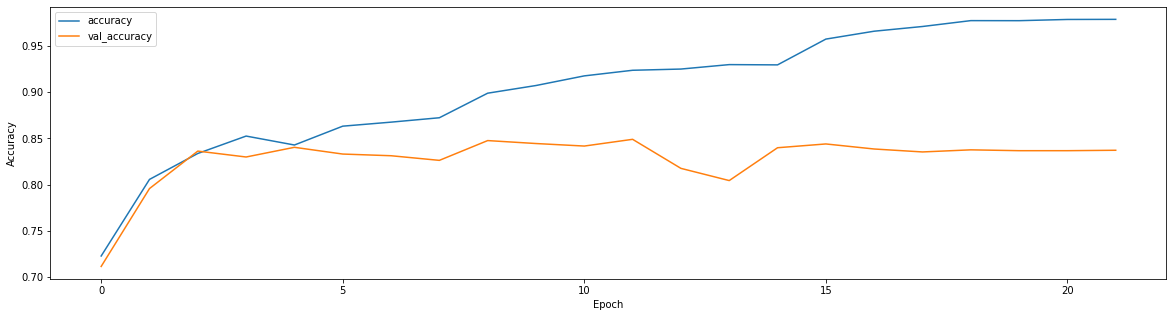

In [ ]:
plt.plot(resNet50_model.history.history['accuracy'])
# plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['val_accuracy'])
# plt.plot(resNet50_model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

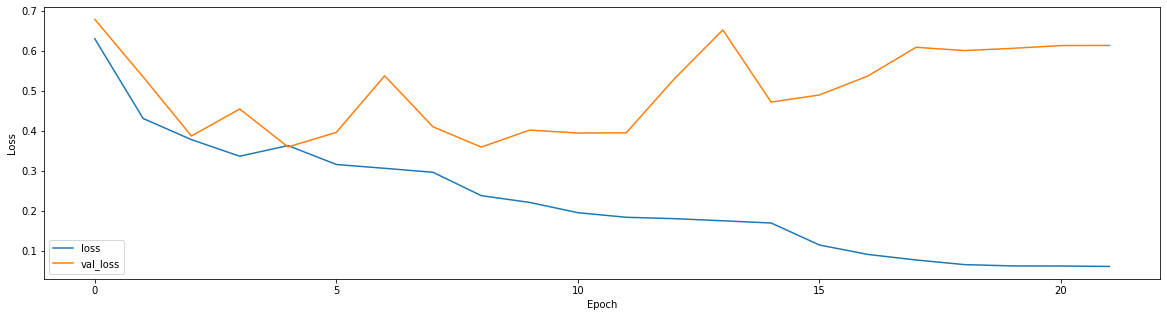

In [ ]:
plt.plot(resNet50_model.history.history['loss'])
plt.plot(resNet50_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# plt.plot(resNet50_model.history.history['Recall'])
# plt.plot(resNet50_model.history.history['Precision'])
# plt.plot(resNet50_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
y5_pred=resNet50_model.predict(test_signal)
predict_5=[int(x+0.5) for x in y5_pred]
vot.append(np.array(predict_5))
conf_mat=confusion_matrix(test_bclass,predict_5)
print(conf_mat)

[[998 241]
 [110 854]]


In [ ]:
accuracy_score(test_bclass,predict_5)

0.8406718111665911

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_bclass, y5_pred)
metrics.auc(fpr, tpr)

0.9183712939427123

**Inseption Model**

In [ ]:
def inception_block(prev_layer):
    
    conv1=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv1=BatchNormalization()(conv1)
    conv1=Activation('relu')(conv1)
    
    conv3=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    conv3=Conv1D(filters = 64, kernel_size = 3, padding = 'same')(conv3)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    
    conv5=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    conv5=Conv1D(filters = 64, kernel_size = 5, padding = 'same')(conv5)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    
    pool= MaxPool1D(pool_size=3, strides=1, padding='same')(prev_layer)
    convmax=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(pool)
    convmax=BatchNormalization()(convmax)
    convmax=Activation('relu')(convmax)
    
    layer_out = concatenate([conv1, conv3, conv5, convmax], axis=1)
    
    return layer_out

def inception_model(input_shape):
    X_input=Input(input_shape)
    
    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(filters = 64, kernel_size = 7, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    
    X = Conv1D(filters = 64, kernel_size = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = inception_block(X)
    X = inception_block(X)
    
    X = MaxPool1D(pool_size=7, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(1,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='Inception')
    
    return model

In [ ]:
inception_model = inception_model(input_shape = (1000,12))

In [ ]:
# inception_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
inception_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# inception_model.summary()

In [ ]:
# plot_model(inception_model)

In [ ]:
batchsize = 32
inception_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=[reduce_lr,early_stop],  validation_data=(v_signal,v_target))

Epoch 1/30
546/546 [==============================] - 38s 63ms/step - loss: 0.3671 - accuracy: 0.8331 - auc: 0.9140 - val_loss: 0.3392 - val_accuracy: 0.8523 - val_auc: 0.9242 - lr: 0.0010
Epoch 2/30
546/546 [==============================] - 33s 61ms/step - loss: 0.3215 - accuracy: 0.8594 - auc: 0.9348 - val_loss: 0.3460 - val_accuracy: 0.8418 - val_auc: 0.9277 - lr: 0.0010
Epoch 3/30
546/546 [==============================] - 33s 60ms/step - loss: 0.3035 - accuracy: 0.8696 - auc: 0.9421 - val_loss: 0.3196 - val_accuracy: 0.8573 - val_auc: 0.9366 - lr: 0.0010
Epoch 4/30
546/546 [==============================] - 33s 61ms/step - loss: 0.2920 - accuracy: 0.8745 - auc: 0.9462 - val_loss: 0.3285 - val_accuracy: 0.8532 - val_auc: 0.9346 - lr: 0.0010
Epoch 5/30
546/546 [==============================] - 33s 61ms/step - loss: 0.2827 - accuracy: 0.8775 - auc: 0.9495 - val_loss: 0.3090 - val_accuracy: 0.8632 - val_auc: 0.9392 - lr: 0.0010
Epoch 6/30
546/546 [==============================] - 3

Text(0, 0.5, 'Accuracy')

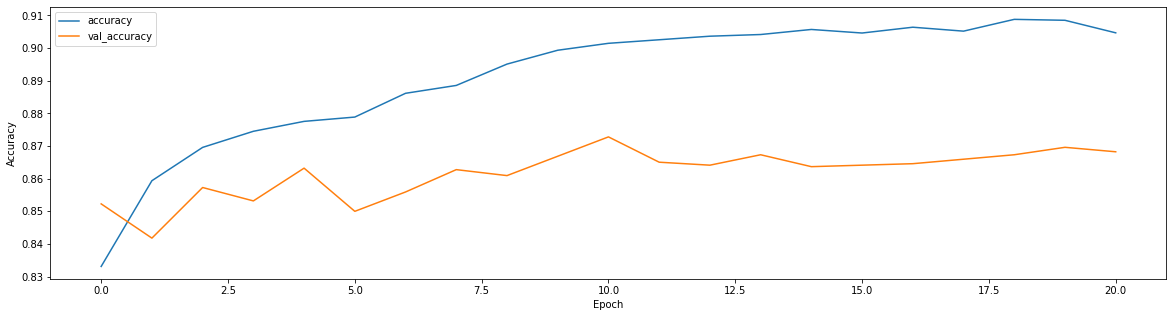

In [ ]:
plt.plot(inception_model.history.history['accuracy'])
# plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['val_accuracy'])
# plt.plot(inception_model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

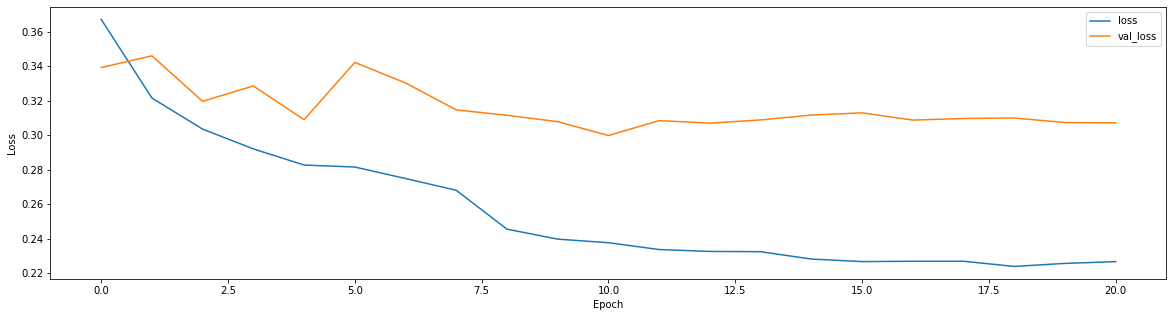

In [ ]:
plt.plot(inception_model.history.history['loss'])
plt.plot(inception_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# plt.plot(inception_model.history.history['Recall'])
# plt.plot(inception_model.history.history['Precision'])
# plt.plot(inception_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
y6_pred=inception_model.predict(test_signal)
predict_6=[int(x+0.5) for x in y6_pred]
vot.append(np.array(predict_6))
conf_mat=confusion_matrix(test_bclass,predict_6)
print(conf_mat)

[[1024  215]
 [  74  890]]


In [ ]:
accuracy_score(test_bclass,predict_6)

0.8688152519291875

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_bclass, y6_pred)
metrics.auc(fpr, tpr)

0.9446682674757786

**RNN Models**

**LSTM Model**

In [ ]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(64, input_shape=(1000,12), return_sequences=True))
# lstm_model.add(LSTM(64))
# lstm_model.add(Dense(32, activation = 'relu'))
# lstm_model.add(Dropout(0.3))
# lstm_model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
#  lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
# lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# lstm_model.summary()

In [ ]:
# plot_model(lstm_model)

In [ ]:
# batchsize = 32
# lstm_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=[reduce_lr,early_stop],  validation_data=(v_signal,v_target))

Epoch 1/30
546/546 [==============================] - 39s 63ms/step - loss: 0.6859 - accuracy: 0.5534 - auc: 0.5286 - val_loss: 0.6798 - val_accuracy: 0.5636 - val_auc: 0.5454 - lr: 0.0010
Epoch 2/30
546/546 [==============================] - 34s 62ms/step - loss: 0.6810 - accuracy: 0.5625 - auc: 0.5393 - val_loss: 0.6600 - val_accuracy: 0.5983 - val_auc: 0.6403 - lr: 0.0010
Epoch 3/30
546/546 [==============================] - 34s 61ms/step - loss: 0.6871 - accuracy: 0.5610 - auc: 0.5281 - val_loss: 0.6842 - val_accuracy: 0.5636 - val_auc: 0.5419 - lr: 0.0010
Epoch 4/30
546/546 [==============================] - 33s 61ms/step - loss: 0.6839 - accuracy: 0.5633 - auc: 0.5151 - val_loss: 0.6819 - val_accuracy: 0.5636 - val_auc: 0.5296 - lr: 0.0010
Epoch 5/30
546/546 [==============================] - 35s 63ms/step - loss: 0.6824 - accuracy: 0.5641 - auc: 0.5213 - val_loss: 0.6701 - val_accuracy: 0.5641 - val_auc: 0.5711 - lr: 0.0010
Epoch 6/30
546/546 [==============================] - 3

Text(0, 0.5, 'Accuracy')

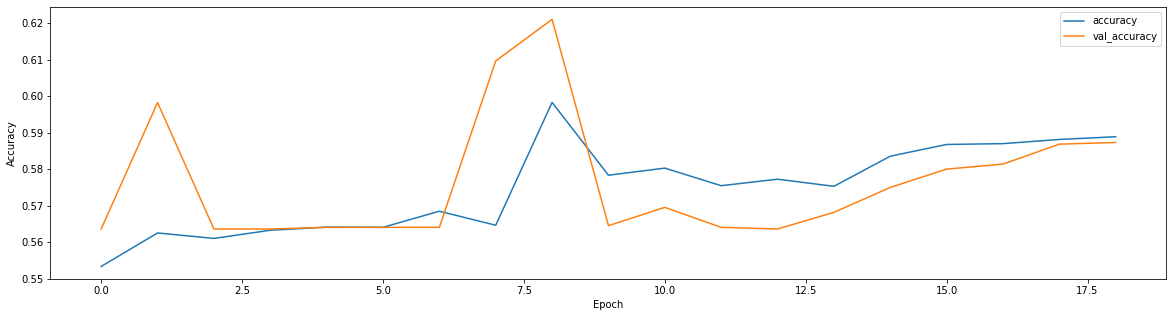

In [ ]:
# plt.plot(lstm_model.history.history['accuracy'])
# # plt.plot(lstm_model.history.history['Precision'])
# plt.plot(lstm_model.history.history['val_accuracy'])
# # plt.plot(lstm_model.history.history['val_Precision'])
# plt.legend(("accuracy","val_accuracy"))
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

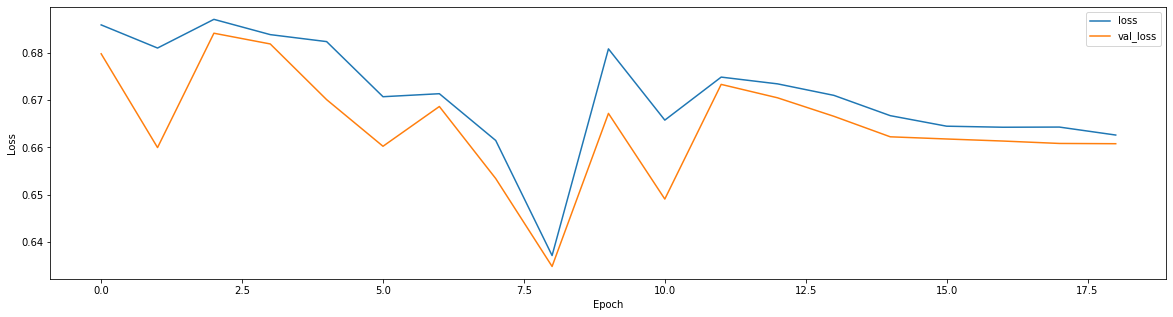

In [ ]:
# plt.plot(lstm_model.history.history['loss'])
# plt.plot(lstm_model.history.history['val_loss'])
# plt.legend(("loss","val_loss"))
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

In [ ]:
# plt.plot(lstm_model.history.history['Recall'])
# plt.plot(lstm_model.history.history['Precision'])
# plt.plot(lstm_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
#ann_model = Sequential()
#ann_model.add(Dense(50, activation='relu'))
#ann_model.add(Dense(50, activation='relu'))
#ann_model.add(Dense(50, activation='relu'))
#ann_model.add(GlobalAveragePooling1D())
#ann_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# y7_pred=lstm_model.predict(test_signal)
# predict_7=[int(x+0.5) for x in y7_pred]
# vot.append(np.array(predict_7))
# conf_mat=confusion_matrix(test_bclass,predict_7)
# print(conf_mat)

[[1103  136]
 [ 766  198]]


In [ ]:
# accuracy_score(test_bclass,predict_7)

0.5905583295506128

In [ ]:
# from sklearn import metrics
# fpr, tpr, thresholds = metrics.roc_curve(test_bclass, y7_pred)
# metrics.auc(fpr, tpr)

0.6574055003533168

**CNN+LSTM**

In [ ]:
# convlstm_model = Sequential()
# convlstm_model.add(Input((10,100,12)))
# convlstm_model.add(ConvLSTM1D(64, kernel_size=2, strides=1, padding = 'same',return_sequences=True))
# convlstm_model.add(BatchNormalization())

# convlstm_model.add(ConvLSTM1D(64,padding = 'same', kernel_size=3))
# convlstm_model.add(Dense(32, activation = 'relu'))
# convlstm_model.add(Dropout(0.3))
# convlstm_model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
# convlstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
# convlstm_model.summary()

In [ ]:
# plot_model(convlstm_model)

In [ ]:
# batchsize = 32
# convlstm_model.fit(x=newsignal, y=target, batch_size=batchsize, epochs=50, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(newv_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

In [ ]:
# plt.plot(convlstm_model.history.history['accuracy'])
# plt.plot(convlstm_model.history.history['Precision'])
# plt.plot(convlstm_model.history.history['val_accuracy'])
# plt.plot(convlstm_model.history.history['val_Precision'])
# plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

In [ ]:
# plt.plot(convlstm_model.history.history['loss'])
# plt.plot(convlstm_model.history.history['val_loss'])
# plt.legend(("loss","val_loss"))
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

In [ ]:
# plt.plot(convlstm_model.history.history['Recall'])
# plt.plot(convlstm_model.history.history['Precision'])
# plt.plot(convlstm_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
input_layer = Input(shape=(1000,12))
conv1 = Conv1D(filters=32,
kernel_size=8,
strides=1,
activation='relu')(input_layer)
pool1 = MaxPool1D(pool_size=4)(conv1)
lstm1 = LSTM(64)(pool1)
output_layer = Dense(1, activation='sigmoid')(lstm1)
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# model.summary()

In [ ]:
# plot_model(model)

In [ ]:
#tf.config.run_functions_eagerly(True)

In [ ]:
batchsize = 32
model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=[reduce_lr,early_stop],  validation_data=(v_signal,v_target))

Epoch 1/30
546/546 [==============================] - 10s 15ms/step - loss: 0.5690 - accuracy: 0.6907 - auc: 0.7630 - val_loss: 0.4652 - val_accuracy: 0.7747 - val_auc: 0.8551 - lr: 0.0010
Epoch 2/30
546/546 [==============================] - 7s 13ms/step - loss: 0.4185 - accuracy: 0.8114 - auc: 0.8860 - val_loss: 0.4362 - val_accuracy: 0.7898 - val_auc: 0.8928 - lr: 0.0010
Epoch 3/30
546/546 [==============================] - 7s 13ms/step - loss: 0.3872 - accuracy: 0.8294 - auc: 0.9023 - val_loss: 0.4069 - val_accuracy: 0.8226 - val_auc: 0.9085 - lr: 0.0010
Epoch 4/30
546/546 [==============================] - 7s 13ms/step - loss: 0.3521 - accuracy: 0.8500 - auc: 0.9197 - val_loss: 0.3576 - val_accuracy: 0.8363 - val_auc: 0.9183 - lr: 0.0010
Epoch 5/30
546/546 [==============================] - 7s 13ms/step - loss: 0.4818 - accuracy: 0.7579 - auc: 0.8389 - val_loss: 0.4346 - val_accuracy: 0.7989 - val_auc: 0.8789 - lr: 0.0010
Epoch 6/30
546/546 [==============================] - 7s 13

Text(0, 0.5, 'Accuracy')

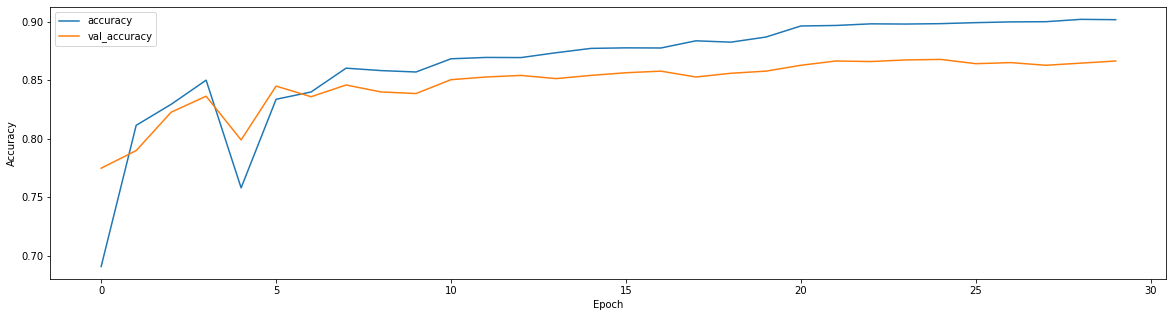

In [ ]:
plt.plot(model.history.history['accuracy'])
#plt.plot(model.history.history['Precision'])
plt.plot(model.history.history['val_accuracy'])
#plt.plot(model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

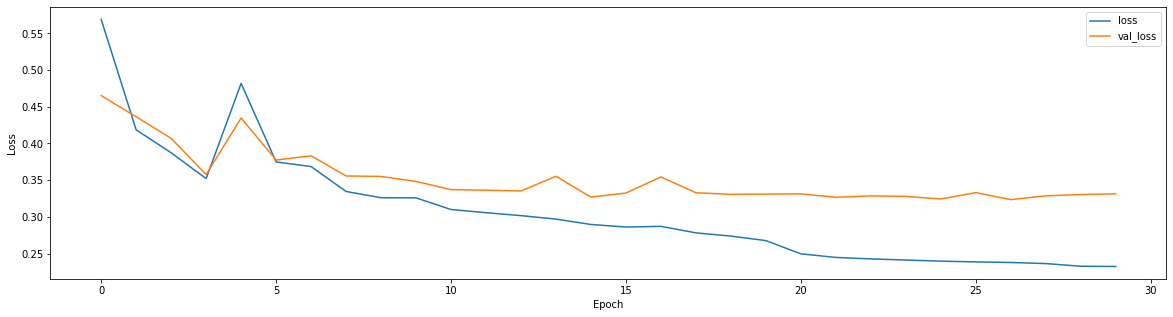

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
y8_pred=model.predict(test_signal)
predict_8=[int(x+0.5) for x in y8_pred]
vot.append(np.array(predict_8))
conf_mat=confusion_matrix(test_bclass,predict_8)
print(conf_mat)

[[1004  235]
 [  90  874]]


In [ ]:
accuracy_score(test_bclass,predict_8)

0.8524738992283251

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_bclass, y8_pred)
metrics.auc(fpr, tpr)

0.9295945398343598

**TCNN**

In [ ]:
!pip install keras-tcn --no-dependencies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tcn import TCN

In [ ]:
def tcn_model(kernel_size = 3, activation='relu'):
    
    inp = Input( shape=(1000,12))
    
    x = SpatialDropout1D(0.1)(inp)
    
    x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn1')(x)
    x = TCN(64,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn2')(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)    

    model = Model(inputs=inp, outputs=outp)
    model.compile( loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy'])
    
    return model

In [ ]:
tcn_model = tcn_model ()

NameError: ignored

**Ensemble**

In [ ]:
y_prob = np.array(vot).transpose()

In [ ]:
y_prob.shape

(2203, 8)

In [ ]:
import collections

In [ ]:
final_out=[]
for i in range(0, y_prob.shape[0]):
  a=np.array(y_prob[i,:])
  a= collections.Counter(a).most_common()[0][0]
  final_out.append(a)

In [ ]:
accuracy_score(test_bclass,final_out)

0.8610985020426691

In [ ]:
classification_report(test_bclass,final_out)

'              precision    recall  f1-score   support\n\n           0       0.92      0.83      0.87      1239\n           1       0.80      0.90      0.85       964\n\n    accuracy                           0.86      2203\n   macro avg       0.86      0.87      0.86      2203\nweighted avg       0.87      0.86      0.86      2203\n'

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_bclass, final_out)
metrics.auc(fpr, tpr)

0.8656919480641261